<a href="https://colab.research.google.com/github/raghavadevarajeurs/DeepLearning/blob/main/Assignment3/Assignment3_PartC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building 3 layer Neural Network using pure Tensorflow tensor with autodifferentiation

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

#Generating sample data for 3d input and 2d output

In [2]:
def get_true_labels(X, weights_true, bias_true):
  return tf.matmul(X ** 2, weights_true, transpose_b=True) + tf.matmul(X, weights_true, transpose_b=True) + tf.transpose(bias_true)

In [3]:
n_samples = 150
input_dim = 3
output_dim = 2

tf.random.set_seed(4)
X = tf.random.uniform((n_samples, input_dim), -1, 1)
print('Sample X: ' + str(X[:2]))

weights_true = tf.constant([[5., 1., 3.], [2., 1., 1.]], dtype=tf.float32)
bias_true = tf.constant([[1], [1]], dtype=tf.float32)

y_true = get_true_labels(X, weights_true, bias_true)
print('Sample y: ' + str(y_true[:2]))

Sample X: tf.Tensor(
[[ 0.9513366   0.11241102 -0.84529805]
 [-0.6738503  -0.71098256 -0.73748803]], shape=(2, 3), dtype=float32)
Sample y: tf.Tensor(
[[10.01463     4.707034  ]
 [-0.88516474  0.16136205]], shape=(2, 2), dtype=float32)


#Drawing the 3 Dimensional data plot

In [4]:
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()

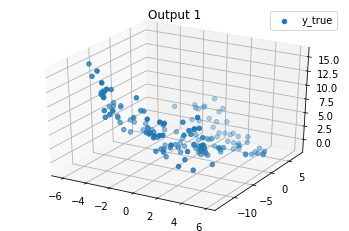

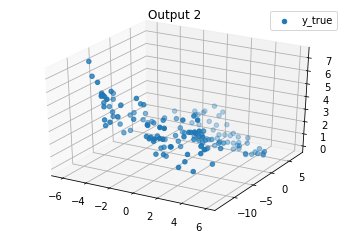

In [5]:
plot_3d('Output 1', X, y_true[:,0])
plot_3d('Output 2', X, y_true[:,1])

#Building Nueral Network

##Loss Function - MSE

In [6]:
class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
  
  def get_error(self):
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
  
  def backward(self):
    return

##Linear Layer

In [7]:
class Layer:
  def __init__(self, num_input_nodes=1, num_output_nodes=1, activation=None):
    self.num_input_nodes = num_input_nodes
    self.num_output_nodes = num_output_nodes
    self.weights = tf.Variable(tf.random.uniform((num_input_nodes, num_output_nodes), -1, 1), name='Layer ({}, {}) Weights'.format(num_input_nodes, num_output_nodes))
    self.bias = tf.Variable(tf.random.uniform((1, 1), -1, 1), name='Layer ({}, {}) Bias'.format(num_input_nodes, num_output_nodes))
    self.X = tf.zeros([num_input_nodes])
    if activation == 'relu':
      self.activation = Relu()
    else: 
      self.activation = None
  
  def forward(self, X):
    self.X = X
    self.Z = tf.matmul(X, self.weights) + tf.transpose(self.bias)
    if self.activation == None:
      return self.Z 
    else:
      return self.activation.forward(self.Z)

  def backward(self, dJdW, dJdb):
    self.dJdW = dJdW
    self.dJdb = dJdb

  def update(self, lr):
    self.weights = self.weights - lr * self.dJdW
    self.weights = tf.Variable(self.weights)
    self.bias = self.bias - lr * self.dJdb
    self.bias = tf.Variable(self.bias)

  def __str__(self):
    return 'Layer: ({},{}) Activation Function: {}\nInputs:\n{}\nWeights:\n{}\nBias:{}'.format(self.num_input_nodes, self.num_output_nodes, self.activation, self.X[:2], self.weights, self.bias)

##ReLU Activation Function

In [8]:
class Relu:
  def __init__(self):
    self.input = tf.constant([], dtype=tf.float32)

  def forward(self, input):
    self.input = input
    self.output = tf.clip_by_value(self.input, clip_value_min=0, clip_value_max=tf.float32.max)
    return self.output
  
  def backward(self, upstream_gradient):
    return
  
  def update(self, lr):
    return

  def __str__(self):
    return 'ReLu'

##Neural Network Architecture

In [9]:
class NeuralNet:
  def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs

    layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]
    
    self.layers = []
    for i in range(len(layers[:-1])):
      if i == len(layers[:-1]) - 1:
        self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
      else:
        self.layers.append(Layer(layers[i], layers[i + 1], activation))

    print('Neural Net Architecture:')
    for i, layer in enumerate(self.layers):
      print('=== Layer {} ==='.format(i))
      print(layer)
    print()

  def forward(self, inputs):
    curr_out = inputs
    for l in self.layers:
      curr_out = l.forward(curr_out)
    return curr_out
  
  def backward(self, y_pred, y_true, tape):
    mse = MSE(y_pred, y_true)
    error = mse.get_error()
    print('Error: ', mean_squared_error(y_true, y_pred))

    for layer in reversed(self.layers):
      [dJdW, dJdb] = tape.gradient(error, [layer.weights, layer.bias])
      layer.backward(dJdW, dJdb)
    
  def update(self, lr):
    for layer in self.layers:
      layer.update(lr)
  
  def fit(self, X, y_true, epochs):
    for i in range(epochs):
      with tf.GradientTape(persistent=True) as tape:
        y_pred = self.forward(X)
        self.backward(y_pred, y_true, tape)
      self.update(lr)

  def __str__(self):
    s = [str(layer) for layer in self.layers]
    return '\n'.join(s)

#HyperParameters

In [10]:
epochs = 150
lr = 0.01

n_inputs = X.shape[1]
n_outputs = y_true.shape[1]

#Training NN with ReLU activation function

In [11]:
nn = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation='relu')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final Error: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: ReLu
Inputs:
[0. 0.]
Weights:
<tf.Variable 'Layer (3, 4) Weights:0' shape=(3, 4) dtype=float32, numpy=
array([[ 0.8993137 , -0.05180287, -0.6799309 ,  0.8145659 ],
       [ 0.8228421 , -0.01230907, -0.70659757,  0.9294169 ],
       [ 0.26166105, -0.44371033, -0.91817045,  0.6864929 ]],
      dtype=float32)>
Bias:<tf.Variable 'Layer (3, 4) Bias:0' shape=(1, 1) dtype=float32, numpy=array([[0.09206796]], dtype=float32)>
=== Layer 1 ===
Layer: (4,3) Activation Function: ReLu
Inputs:
[0. 0.]
Weights:
<tf.Variable 'Layer (4, 3) Weights:0' shape=(4, 3) dtype=float32, numpy=
array([[ 0.63150287,  0.96044135, -0.6330464 ],
       [ 0.29742074, -0.96691823,  0.7850721 ],
       [-0.9131329 ,  0.13237166,  0.16325712],
       [-0.76590586,  0.00552201, -0.13452601]], dtype=float32)>
Bias:<tf.Variable 'Layer (4, 3) Bias:0' shape=(1, 1) dtype=float32, numpy=array([[0.7875974]], dtype=float32)>
=== Layer 2 ===
Layer: (3,2) Ac

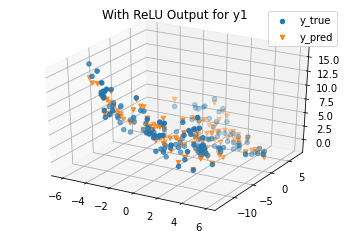

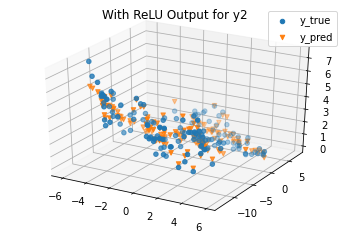

In [12]:
plot_3d('With ReLU Output for y1', X, y_true[:,0], y_pred[:,0])
plot_3d('With ReLU Output for y2', X, y_true[:,1], y_pred[:,1])

#Training NN without any activation function


In [13]:
nn = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation=None)
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final Error: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: None
Inputs:
[0. 0.]
Weights:
<tf.Variable 'Layer (3, 4) Weights:0' shape=(3, 4) dtype=float32, numpy=
array([[-0.35700798, -0.970232  ,  0.4530878 , -0.5754149 ],
       [ 0.90835404, -0.14789486,  0.35019183,  0.7755692 ],
       [ 0.6711004 , -0.61123204, -0.3805008 ,  0.19070148]],
      dtype=float32)>
Bias:<tf.Variable 'Layer (3, 4) Bias:0' shape=(1, 1) dtype=float32, numpy=array([[0.3075807]], dtype=float32)>
=== Layer 1 ===
Layer: (4,3) Activation Function: None
Inputs:
[0. 0.]
Weights:
<tf.Variable 'Layer (4, 3) Weights:0' shape=(4, 3) dtype=float32, numpy=
array([[-0.05168366,  0.43672252, -0.9954922 ],
       [-0.85245585,  0.07808876, -0.45187974],
       [-0.6147814 , -0.43732524, -0.59802413],
       [-0.41415405, -0.2941265 , -0.01377487]], dtype=float32)>
Bias:<tf.Variable 'Layer (4, 3) Bias:0' shape=(1, 1) dtype=float32, numpy=array([[-0.42177534]], dtype=float32)>
=== Layer 2 ===
Layer: (3,2) A

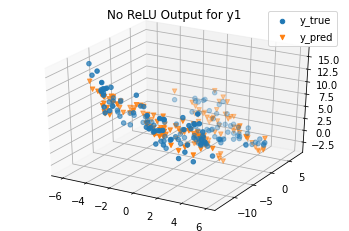

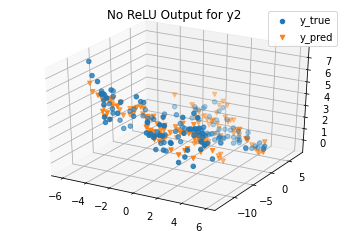

In [14]:
plot_3d('No ReLU Output for y1', X, y_true[:,0], y_pred[:,0])
plot_3d('No ReLU Output for y2', X, y_true[:,1], y_pred[:,1])